<a href="https://colab.research.google.com/github/peterchang0414/randomized_priors/blob/main/randomized_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Randomized Prior Functions for Deep Reinforcement Learning
Based on Osband et al 2018: https://proceedings.neurips.cc/paper/2018/file/5a7b238ba0f6502e5d6be14424b20ded-Paper.pdf

Adapted to JAX from https://www.kaggle.com/code/gdmarmerola/introduction-to-randomized-prior-functions/notebook

Author: Peter G. Chang ([@peterchang0414](https://github.com/peterchang0414))

# 0. Imports

In [1]:
!pip -q install flax

     |████████████████████████████████| 184 kB 5.4 MB/s 
     |████████████████████████████████| 136 kB 45.0 MB/s 
     |████████████████████████████████| 72 kB 604 kB/s 


In [2]:
%matplotlib inline

from functools import partial
import matplotlib.pyplot as plt

import optax
import jax
import jax.numpy as jnp
from jax import jit
from jax.nn.initializers import glorot_normal

import flax
import flax.linen as nn
from flax.training import train_state

# 1. Simple Example

Generate dataset [using](https://arxiv.org/pdf/1505.05424.pdf):
$$
y = x + 0.3 \sin(2 \pi(x + \epsilon)) + 0.3 \sin(4 \pi(x + \epsilon)) + \epsilon
$$
where $\epsilon \sim \mathcal{N}(0, 0.02)$ and $x \sim \mathcal{U}(0.0, 0.5)$.


In [3]:
# Generate dataset and grid
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X = jax.random.uniform(key, shape=(100, 1), minval=0.0, maxval=0.5)
x_grid = jnp.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(key, x):
  epsilons = jax.random.normal(key, shape=(3,))*0.02
  return (x + 0.3*jnp.sin(2*jnp.pi*(x+epsilons[0])) + 
          0.3*jnp.sin(4*jnp.pi*(x+epsilons[1])) + epsilons[2])

# Define vectorized version of function
target_vmap = jax.vmap(target_toy, in_axes=(0, 0), out_axes=0)

# Generate target values
keys = jax.random.split(subkey, X.shape[0])
Y = target_vmap(keys, X)

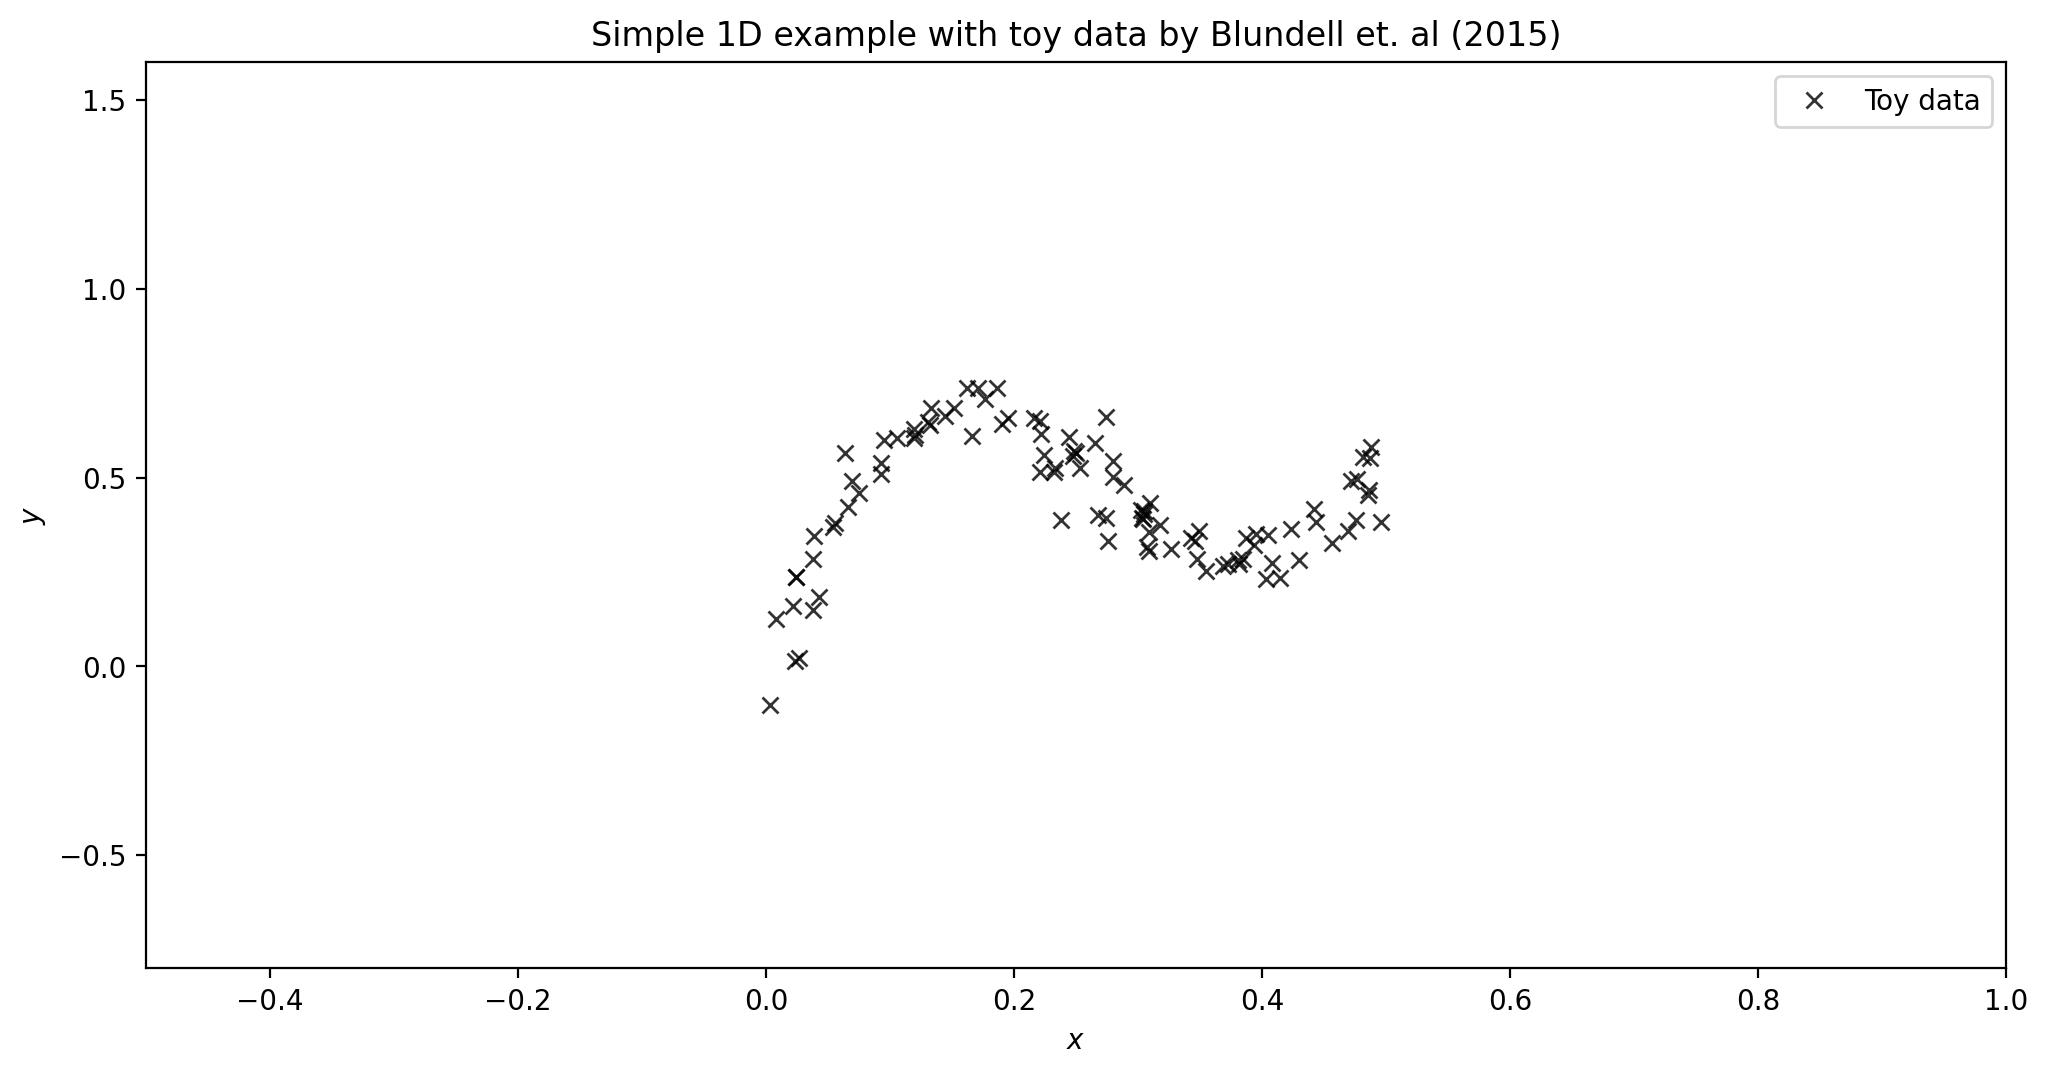

In [4]:
# Plot the generated data
plt.figure(figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-0.8,1.6)
plt.legend();
plt.show()

#2. Randomized Prior Functions

In [5]:
# Prior and trainable networks have the same architecture
class GenericNet(nn.Module):
  @nn.compact
  def __call__(self, x):
    dense = partial(nn.Dense, kernel_init=glorot_normal())
    return nn.Sequential([dense(16), nn.elu, dense(16), nn.elu, dense(1)])(x)

# Model that combines prior and trainable nets
class Model(nn.Module):
  prior: GenericNet
  trainable: GenericNet
  beta: int

  @nn.compact
  def __call__(self, x):
    x1 = self.prior(x)
    x2 = self.trainable(x)
    return self.beta*x1 + x2

In [6]:
def create_train_state(key, X, beta):
  key, _ = jax.random.split(key)
  model = Model(prior=GenericNet(), trainable=GenericNet(), beta=beta)
  params = model.init(key, X)['params']
  p_params, t_params = params['prior'], params['trainable']
  opt = optax.adam(learning_rate=0.03)
  return p_params, train_state.TrainState.create(apply_fn=model.apply, 
                                                 params=t_params, tx=opt)

@jax.jit
def train_epoch(p_params, train_state, X, Y):
  def loss_fn(params):
    model = Model(prior=GenericNet(), trainable=GenericNet(), beta=3)
    Yhat = model.apply({'params': {'prior': p_params, 'trainable': params}}, X)
    loss = jnp.mean((Yhat - Y)**2)
    return loss
  Yhats, grads = jax.value_and_grad(loss_fn)(train_state.params)
  train_state = train_state.apply_gradients(grads=grads)
  return train_state

def train(key, X, Y, beta, epochs):
  p_params, train_state = create_train_state(key, X, beta)
  for epoch in range(1, epochs + 1):
    train_state = train_epoch(p_params, train_state, X, Y)
  return p_params, train_state.params

In [13]:
params = train(jax.random.PRNGKey(0), X, Y, 3, 2000)

In [19]:
# Prediction function to be resued in Part 3
def get_predictions(X, params):
  prior, trainable = params
  generic = GenericNet()
  model = Model(prior=GenericNet(), trainable=GenericNet(), beta=3)
  Y_prior = generic.apply({'params': prior}, x_grid)
  Y_trainable = generic.apply({'params': trainable}, x_grid)
  Y_model = model.apply({'params': {'prior': prior, 'trainable': trainable}}, 
                        x_grid)
  return Y_prior, Y_trainable, Y_model

In [15]:
Y_prior, Y_trainable, Y_model = get_predictions(x_grid, params)

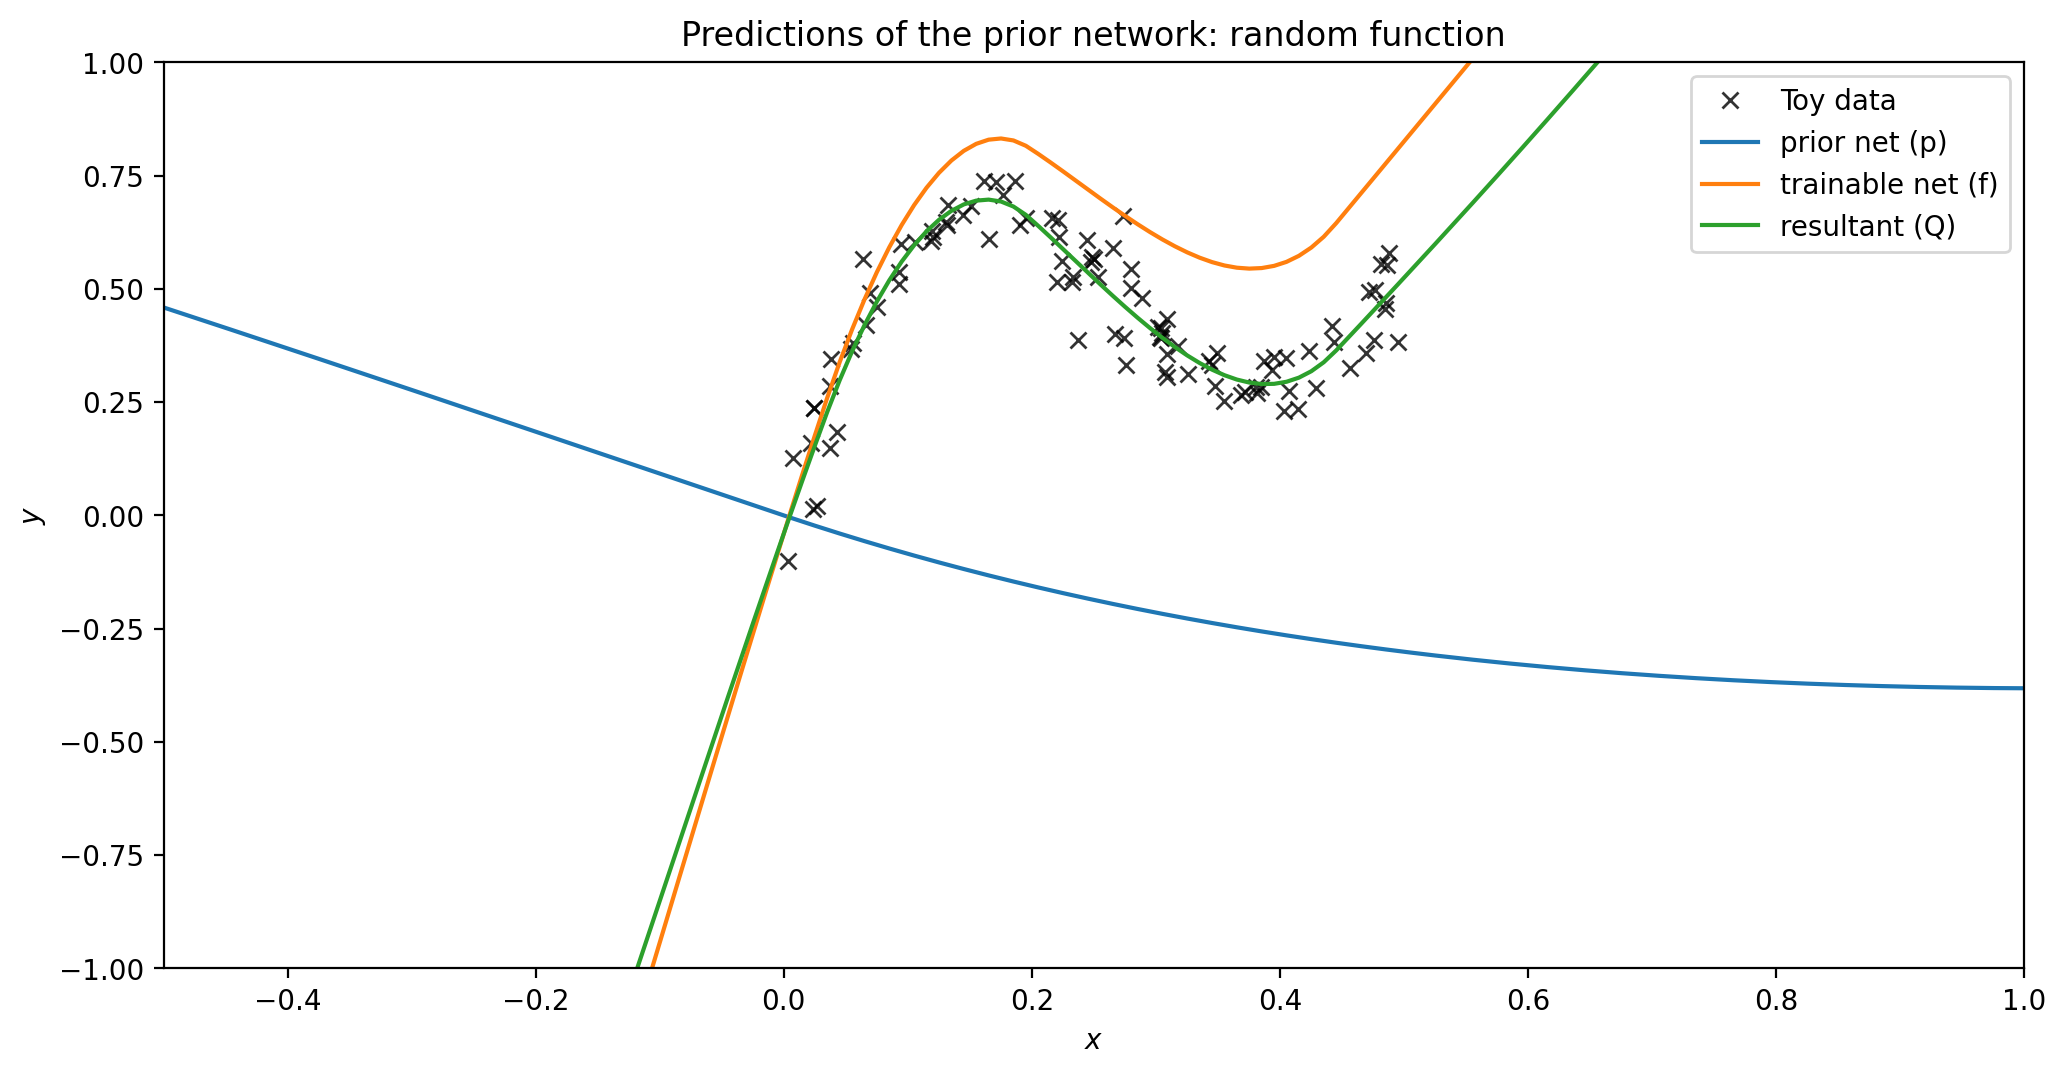

In [16]:
# Plot the results
plt.figure(figsize=[12,6], dpi=200)
plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
plt.plot(x_grid, 3*Y_prior, label='prior net (p)')
plt.plot(x_grid, Y_trainable, label='trainable net (f)')
plt.plot(x_grid, Y_model, label='resultant (Q)')
plt.title('Predictions of the prior network: random function')
plt.xlabel('$x$'); plt.ylabel('$y$')
plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.legend();
plt.show()

# 3. Bootstrapped Ensembles

To implement bootstrapping using JAX, we generate a random map from seed values to dataset index values: $\{\text{seed}, \text{seed}+1 \dots, \text{seed}+99\} \to \{ 0, 1, \dots, 99 \}$ by utilizing ``` jax.random.randint ```  using a randomly-generated seed. We assume the random key space is large enough that we need not be concerned with generating overlapping seed ranges.

In [10]:
def generate_bootstrap(key, size):
  seed, _ = jax.random.split(key)
  return [jax.random.randint(seed+i, (), 0, size) for i in range(size)]

In [22]:
# An ensemble model with randomized prior nets
def build_ensemble(n_estimators, beta, X, Y):
  ensemble = []
  for i in range(n_estimators):
    key, subkey = jax.random.split(jax.random.PRNGKey(i))
    bootstrap = jnp.array(generate_bootstrap(key, X.shape[0]))
    X_b, Y_b = jnp.take(X, bootstrap), jnp.take(Y, bootstrap)
    key, _ = jax.random.split(subkey)
    ensemble.append(train(key, X, Y, 3, 3000))
  return ensemble

In [28]:
# Array of predictions for each model in trained ensemble
def get_ensemble_predictions(n_estimators, beta, X, Y, X_new):
  prior_grid, trainable_grid, y_grid = [], [], []
  for model_params in build_ensemble(n_estimators, beta, X, Y):
    Y_prior, Y_trainable, Y_model = get_predictions(x_grid, model_params)
    prior_grid.append(Y_prior)
    trainable_grid.append(Y_trainable)
    y_grid.append(Y_model)
  return jnp.array(prior_grid), jnp.array(trainable_grid), jnp.array(y_grid)

In [29]:
prior_grid, trainable_grid, y_grid = get_ensemble_predictions(9, 3, X, Y, x_grid)

In [31]:
y_grid.shape

(9, 1000, 1)

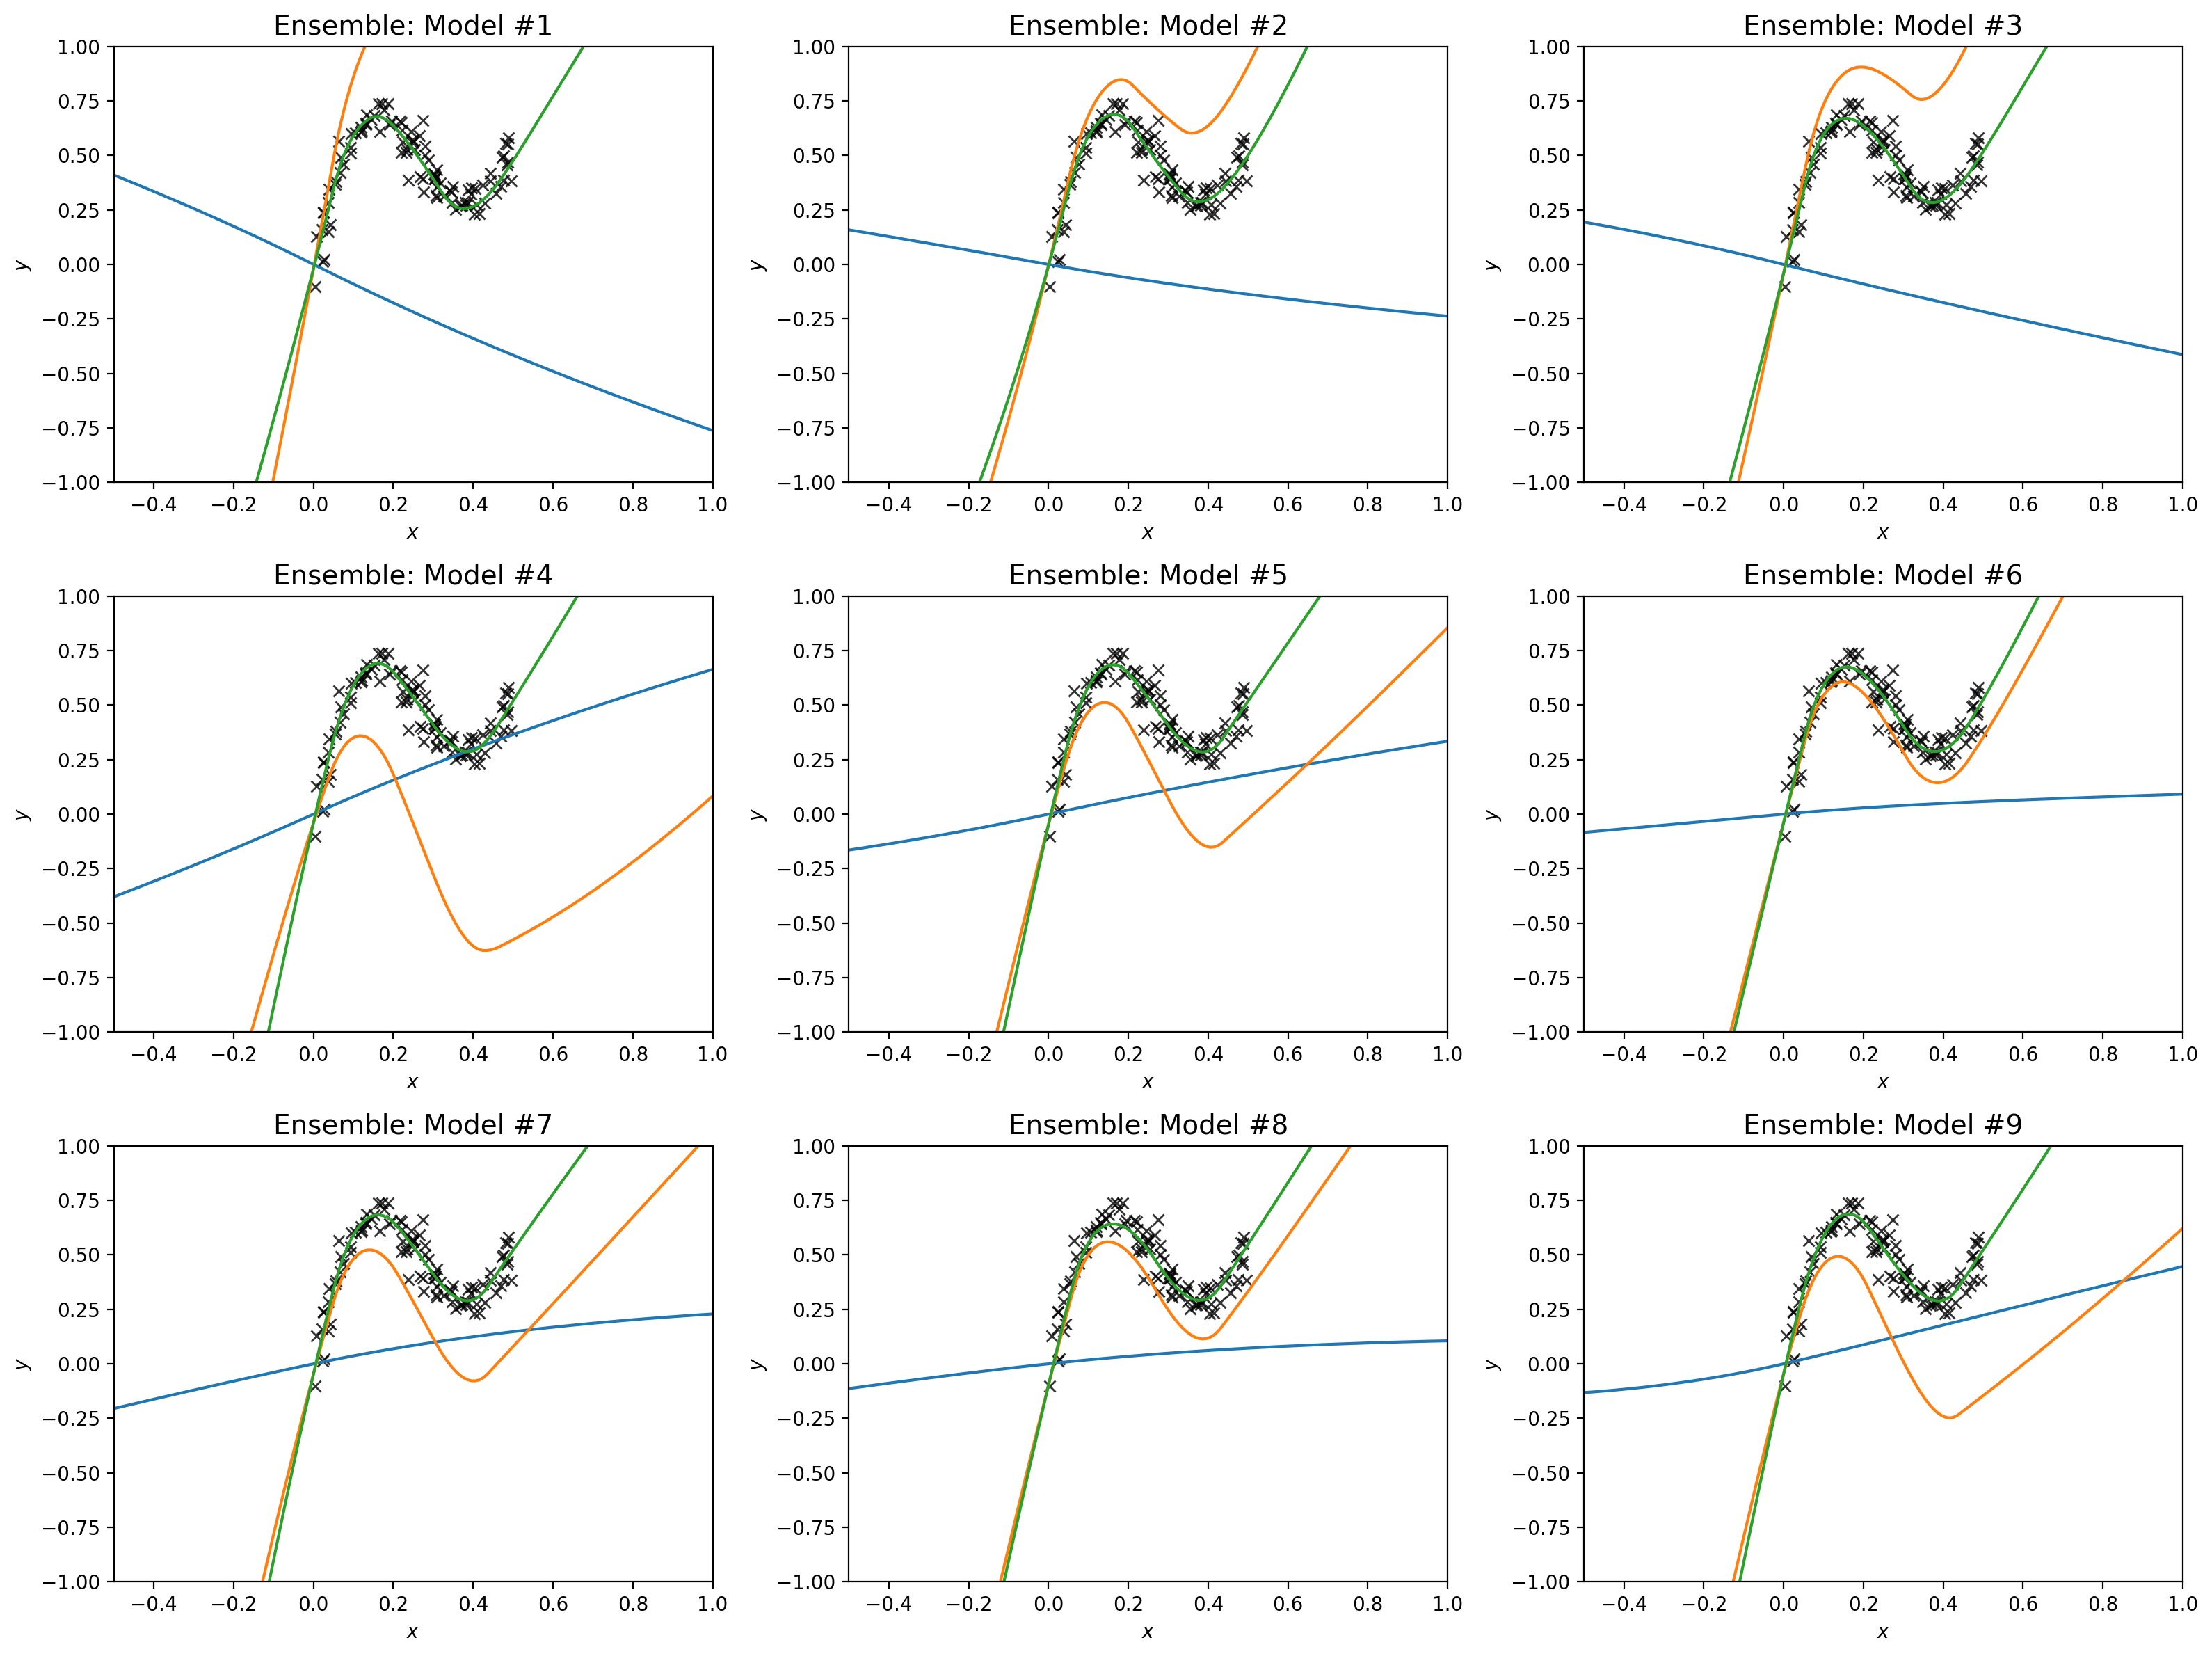

In [33]:
# Plot the results
plt.figure(figsize=[16,12], dpi=200)
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.plot(X, Y, 'kx', label='Toy data', alpha=0.8)
    plt.plot(x_grid, prior_grid[i,:,0], label='prior net (p)')
    plt.plot(x_grid, trainable_grid[i,:,0], label='trainable net (f)')
    plt.plot(x_grid, y_grid[i,:,0], label='resultant (Q)')
    plt.title('Ensemble: Model #{}'.format(i+1), fontsize=14)
    plt.xlabel('$x$'); plt.ylabel('$y$')
    plt.xlim(-0.5,1.0); plt.ylim(-1.0,1.0)
plt.tight_layout()
plt.show();